# Unsupervised Learning (Final Version)

1. LDA Topic Modeling on Consumer Complaints Narrative
2. Association Rule Mining
3. Finding Similar Complaints with Word2Vec and Cosine Similarity
4. Clustering Companies Based On Complaints

4 methods, each inc at least 2 vis.

team: f23-milestone2-team10-yehch-yihsinc-weimingc

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import re
import string
from tqdm import tqdm
tqdm.pandas()
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud


from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import networkx as nx
from gensim.models import KeyedVectors

from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics.pairwise import cosine_similarity

from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

# suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
filepath01 = 'complaints.csv'
filepath02 = 'GoogleNews-vectors-negative300.bin.gz'

# Google drive file path
# filepath01 = '/content/drive/My Drive/Colab Notebooks/assets/complaints.csv'
# filepath02 = '/content/drive/My Drive/Colab Notebooks/assets/GoogleNews-vectors-negative300.bin.gz'

DATA = pd.read_csv(filepath01)

## 1. LDA Topic Modeling on Consumer Complaints Narrative

Use topic modeling (e.g., LDA) to identify common themes/topics from the narratives.

In [450]:
# make a copy of the data
df = DATA.copy()
print(df.shape)

# drop null narratives
df = df.dropna(subset=['Consumer complaint narrative'])
print(df.shape)

(4028530, 18)
(1460126, 18)


In [451]:
# draw random sample of 10000 rows of the data for faster processing and demonstration purposes
df = df.sample(n=10000, random_state=42)

print(df.shape)

(10000, 18)


In [452]:
# Reusable function:
# preprocess the narrative column

def preprocess_narrative(text):
    # Lowercase
    text = text.lower()

    # Remove XXXX like pattern
    text = re.sub(r'x{2,}', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing spaces
    text = text.strip()

    return text

In [453]:
# preprocess the narrative column to column 'narrative_clean'
df['narrative_clean'] = df['Consumer complaint narrative'].progress_apply(preprocess_narrative)

# check the result
df['narrative_clean'].sample(3).to_dict()

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 9503.73it/s]


{3371466: 'ordered bedroom set bedroom set arrived local courier however couldnt locate items kept following trace items point ordered another bedroom set different company asked cancel order refund money come found items insists delivering longer need items deemed missing months called capital one dispute charges avail called trying charge return fee',
 652208: 'victim identity theft someone destroying life fraud accounts dont know getting credit together see fraudulent accounts never authoirized accounts please investigate criminals',
 3253338: 'working loan modification within wells fargo told anything process complete listening im months behind due poor communication refuse help payment plan forced loan review never came solution tried force short sale refuse help get caught'}

In [479]:
# convert to tf-idf representation

vectorizer_tfidf = TfidfVectorizer(max_features=1000)

narrative_tfidf = vectorizer_tfidf.fit_transform(df['narrative_clean'])

print(narrative_tfidf.shape)

feature_names = vectorizer_tfidf.get_feature_names_out()

(10000, 1000)


In [480]:
# Extracting topics and their top words
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(tqdm(model.components_, desc='Processing topics', unit='topic')):
        topics.append(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return topics

In [473]:
# Training the LDA model with 3 topics
n_topics = 3
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)
lda_model.fit(narrative_tfidf)

# number of top words to display for each topic
no_top_words = 10

# get the topics and their top words
topics = display_topics(lda_model, feature_names, no_top_words)

# Print the topics
print(topics)

Processing topics: 100%|██████████| 3/3 [00:00<00:00, 4322.54topic/s]

['account bank payment loan card would told called credit paid', 'credit report information accounts debt reporting account bureaus items equifax', 'consumer section usc states account reporting identity theft agency credit']


In [474]:
# function to generate word cloud for a given topic
def generate_wordcloud(topic, ax):
    wordcloud = WordCloud(background_color='white', max_words=50, contour_width=3, contour_color='steelblue')
    wordcloud.generate(topic)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')


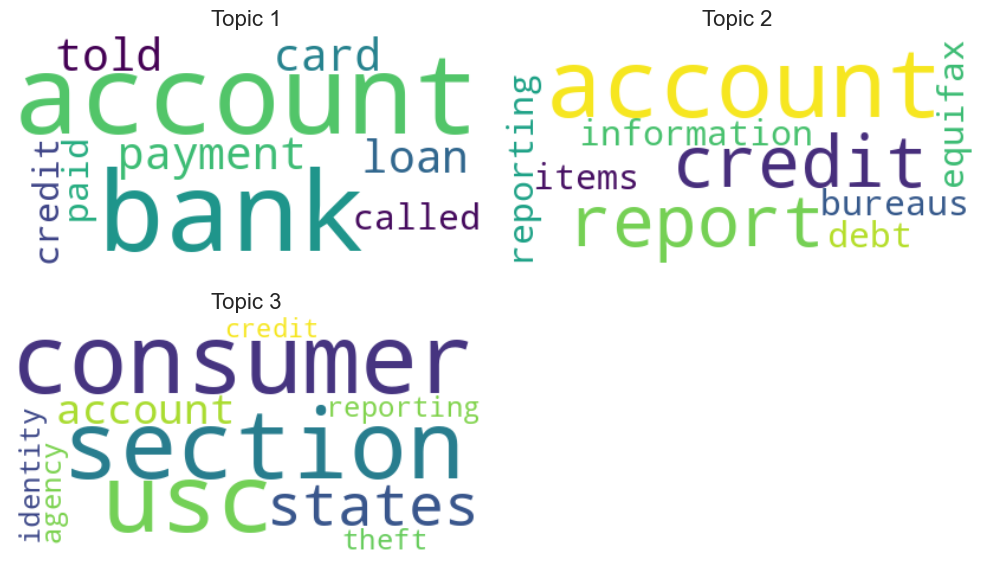

In [481]:
# Visualizing the topics using word clouds with 3 topics
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:3]):

    # Generate word cloud for the topic
    generate_wordcloud(topics[i], ax)

    # Add topic as title for each subplot
    ax.set_title('Topic ' + str(i+1), fontdict=dict(size=16))


# Turn off the axis for the sixth grid
axes.flatten()[3].axis('off')

plt.tight_layout()

plt.show()

#### Vis: Hyperparameters tuning

Processing topics: 100%|██████████| 15/15 [00:00<00:00, 7594.71topic/s]


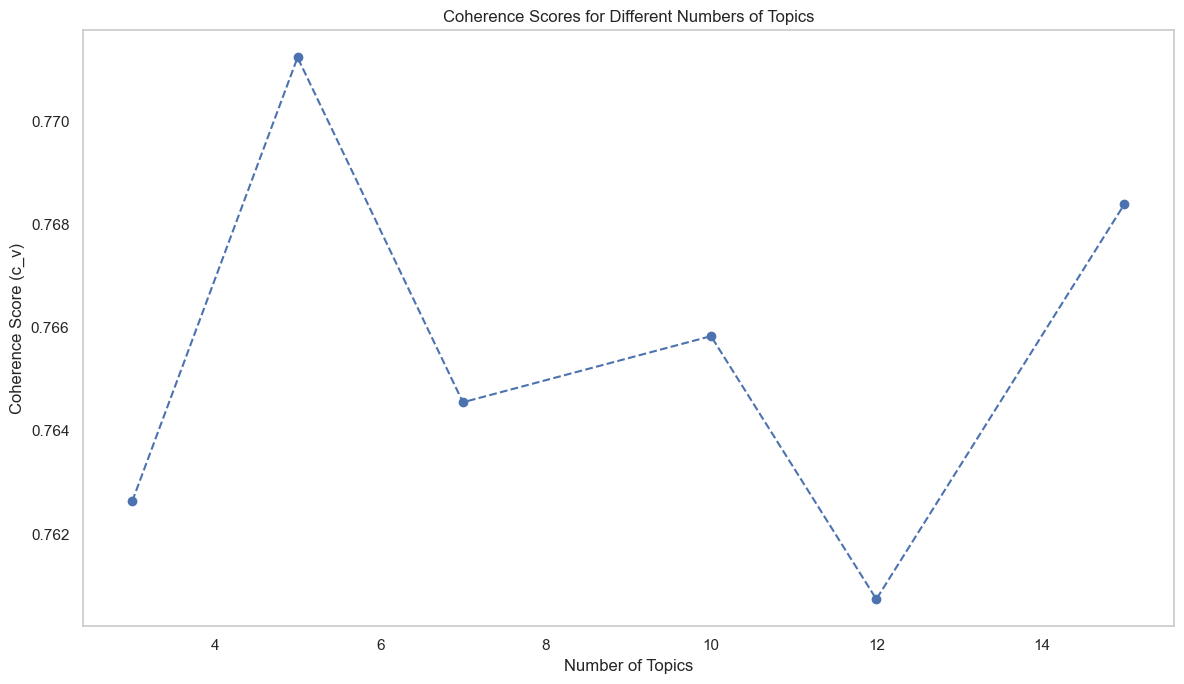

In [482]:
# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(df['narrative_clean'].str.split())

# Filter out words that occur less than 10 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.5)

# Define function to compute coherence score for a given LDA model and corpus
def compute_coherence(lda_model, texts, dictionary):
    topics = display_topics(lda_model, feature_names, no_top_words=10)
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Lists to hold number of topics and corresponding coherence values
num_topics_list = [3, 5, 7, 10, 12]
coherence_values = []

for num_topics in num_topics_list:
    # Train LDA model
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42, max_iter=10)
    lda_model.fit(narrative_tfidf)
    
    # Compute coherence score
    coherence = compute_coherence(lda_model, df['narrative_clean'].str.split(), dictionary)
    coherence_values.append(coherence)

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(num_topics_list, coherence_values, marker='o', linestyle='--')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence Scores for Different Numbers of Topics")
plt.grid()
plt.tight_layout()
plt.show()



In [483]:
# zip coherence_values and num_topics_list to dictionary
coherence_dict = dict(zip(num_topics_list, coherence_values))

# print the coherence scores
for num_topics, coherence_score in coherence_dict.items():
    print("Number of Topics =", num_topics, " has Coherence Value of", round(coherence_score, 4))

# select the number of topics with the highest coherence score
best_num_topics = max(coherence_dict, key=coherence_dict.get)
print("\nOptimal Number of Topics =", best_num_topics)

Number of Topics = 3  has Coherence Value of 0.7626
Number of Topics = 5  has Coherence Value of 0.7712
Number of Topics = 7  has Coherence Value of 0.7646
Number of Topics = 10  has Coherence Value of 0.7658
Number of Topics = 12  has Coherence Value of 0.7607
Number of Topics = 15  has Coherence Value of 0.7684

Optimal Number of Topics = 5


In [485]:
# train the LDA model with the optimal number of topics
lda_model = LatentDirichletAllocation(n_components=best_num_topics, random_state=42, max_iter=10)
lda_model.fit(narrative_tfidf)

# get the topics and their top words
topics = display_topics(lda_model, feature_names, no_top_words=10)

# print the topics
for idx, topic in enumerate(topics):
    print("Topic " + str(idx+1) + ":")
    print(topic)
    print("")


Processing topics: 100%|██████████| 5/5 [00:00<00:00, 2598.70topic/s]

Topic 1:
account bank card told would payment called money call received

Topic 2:
credit report debt information account reporting accounts collection inaccurate letter

Topic 3:
identity credit report theft inquiries inquiry fraudulent accounts victim remove

Topic 4:
consumer section usc reporting states account agency privacy furnish rights

Topic 5:
loan mortgage credit payments payment loans late score student home


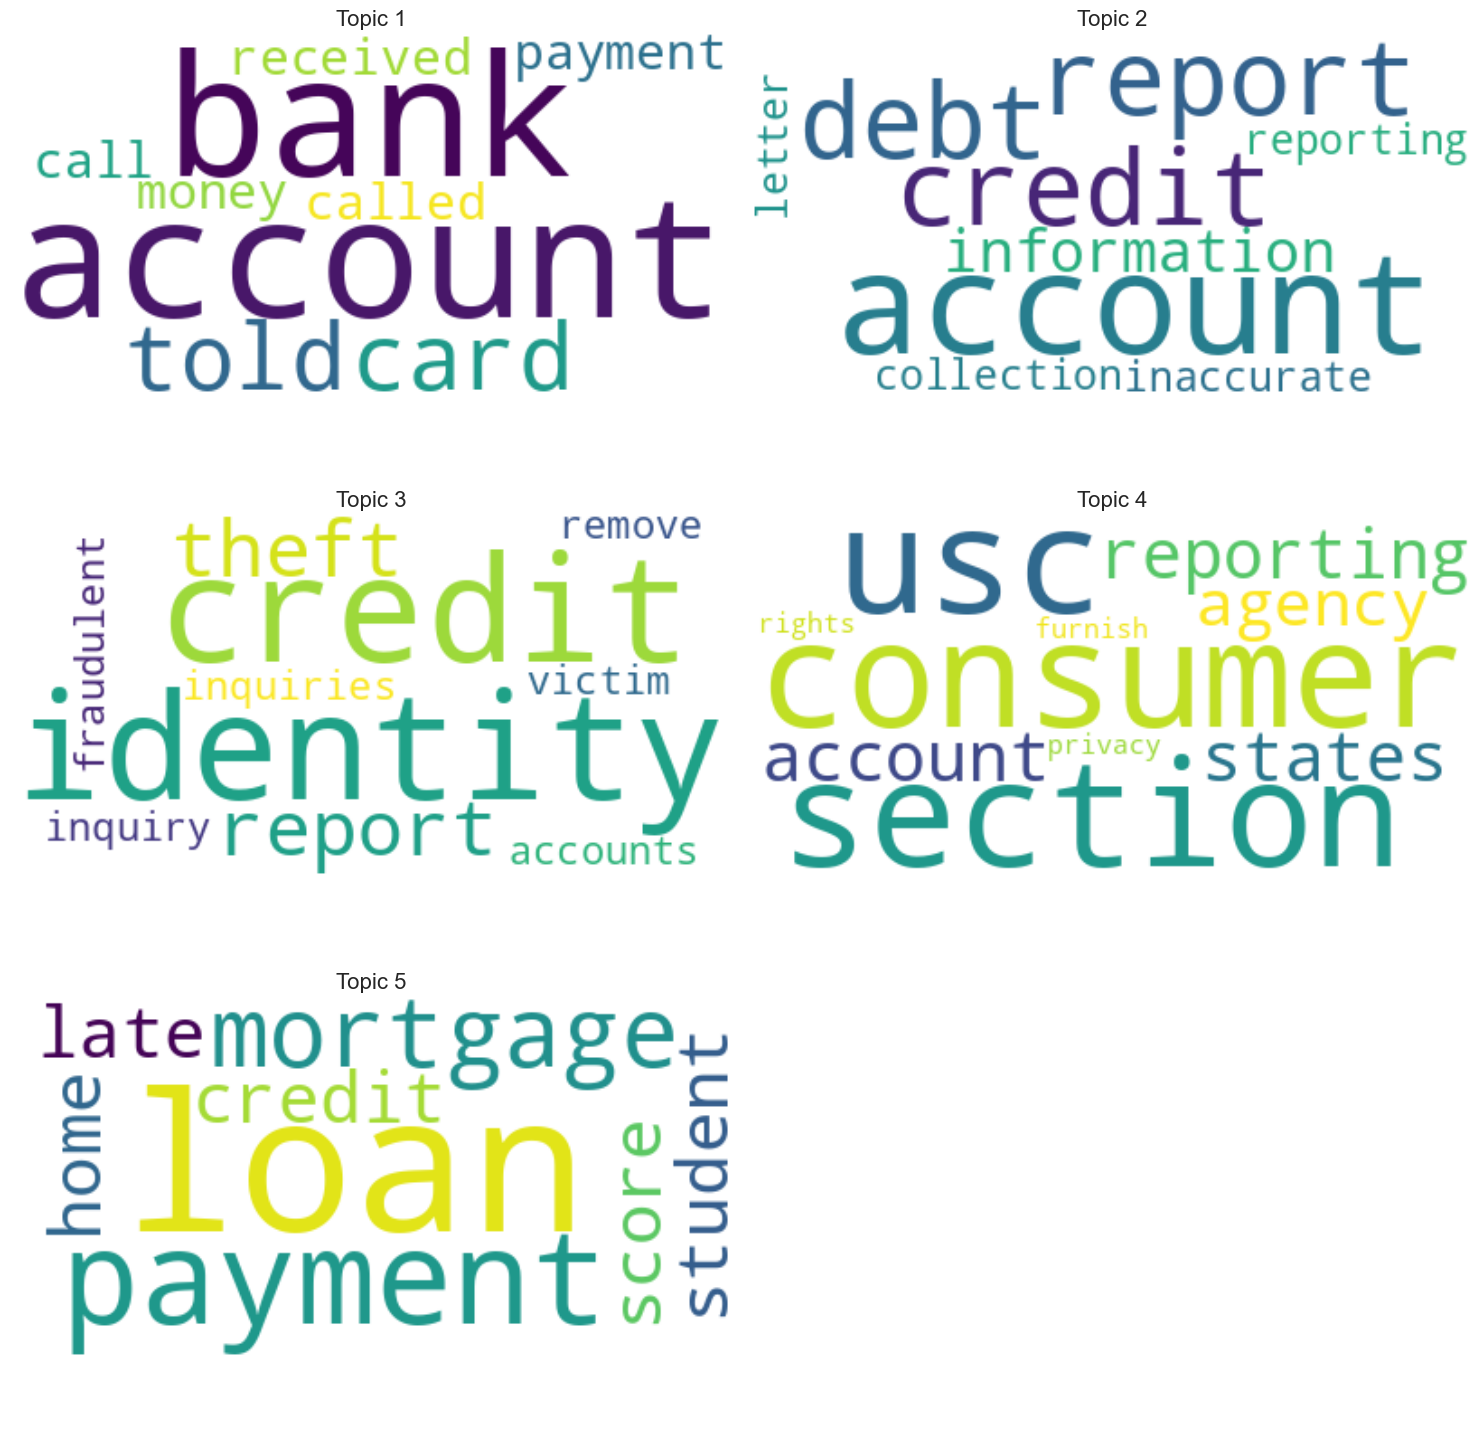

In [486]:

# Visualizing the topics using word clouds
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for i, ax in enumerate(axes.flatten()[:5]):
    # Generate word cloud for the topic
    generate_wordcloud(topics[i], ax)

    # Add topic as title for each subplot
    ax.set_title('Topic ' + str(i+1), fontdict=dict(size=16))

# Turn off the axis for the sixth grid
axes.flatten()[5].axis('off')

plt.tight_layout()

plt.show()



#### Vis: Topic Distribution: distribution of complaints across the identified topics.

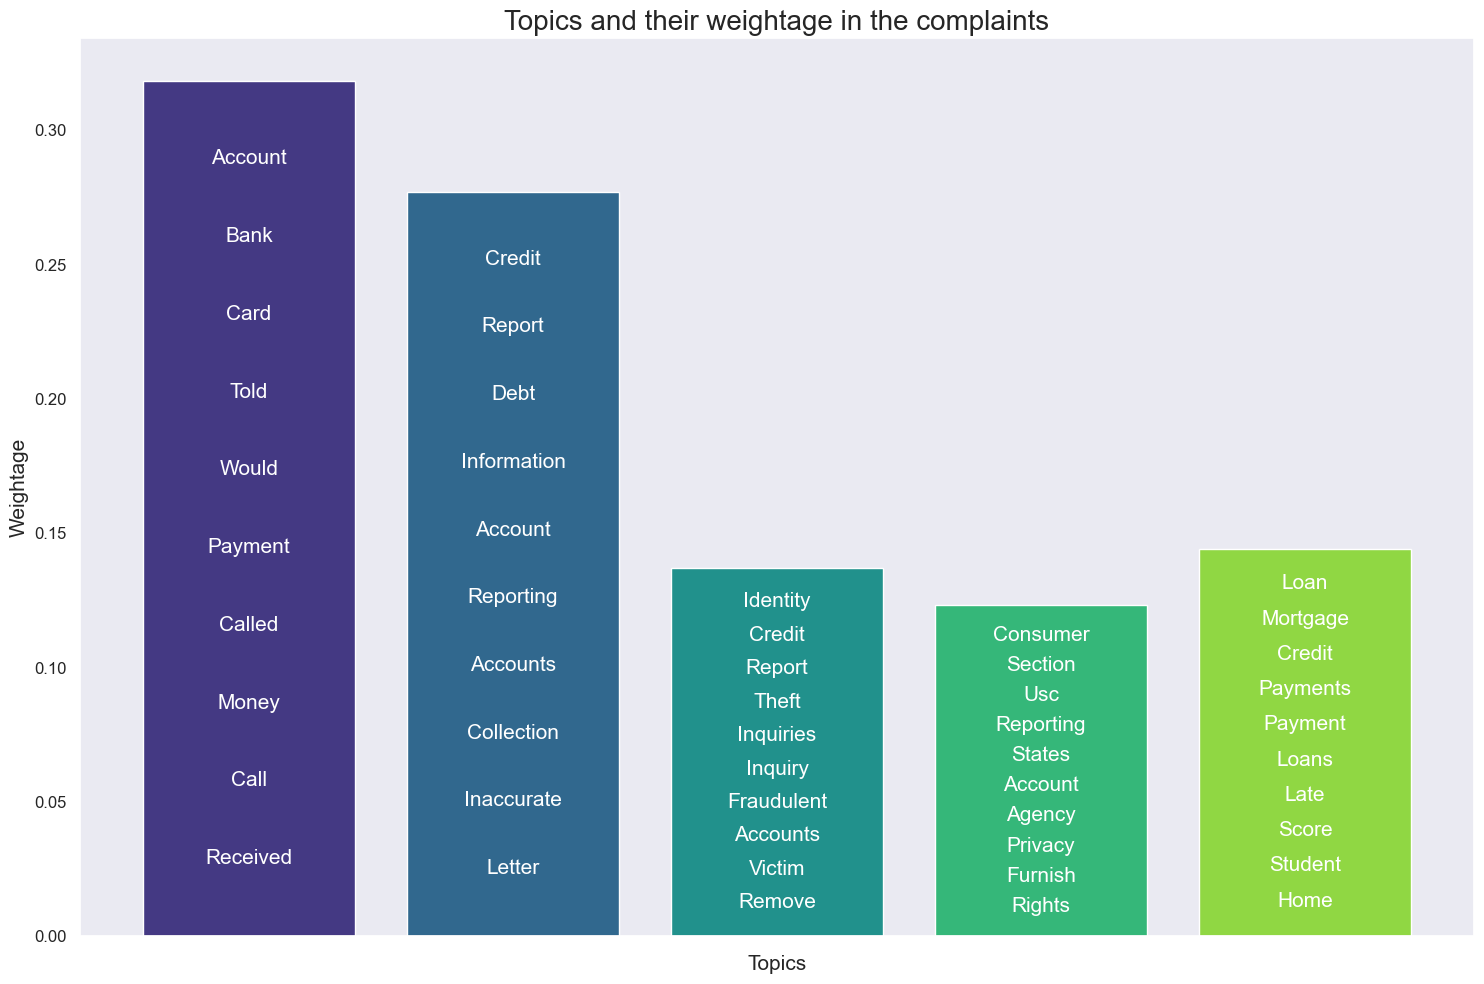

In [489]:
# Set the style
sns.set_style("dark")

# Get topic distribution for each document
topic_dist = lda_model.transform(narrative_tfidf) 

# Aggregate topic distribution across all documents
topic_counts = topic_dist.sum(axis=0)

# Convert counts to percentages
topic_percentages = topic_counts / topic_counts.sum()

# Create bar chart with topic keywords and their weightage in each topic
fig, ax = plt.subplots(figsize=(15, 10))

# Bar plot
bars = ax.bar(x=range(len(topic_percentages)), height=topic_percentages, tick_label=['' for _ in topics], color=sns.color_palette("viridis", len(topic_percentages)))  # Use the viridis color palette

# Set title and labels for axes
ax.set_xlabel('Topics', fontsize=15)
ax.set_ylabel('Weightage', fontsize=15)
ax.set_title('Topics and their weightage in the complaints', fontsize=20)

# Set tick size for x and y axes
ax.tick_params(axis='both', labelsize=12)

# Overlay topics on bars, word by word
for bar, topic in zip(bars, topics):
    y_val = bar.get_height()
    words = topic.split()

    # capitalize the first letter of each word
    words = [word.capitalize() for word in words]

    # reverse the list of words to start from the top of the bar
    words.reverse()

    n_words = len(words)
    word_spacing = y_val / (n_words + 1)
    for i, word in enumerate(words):
        y_position = word_spacing * (i + 1)
        ax.text(bar.get_x() + bar.get_width() / 2, y_position, word, ha='center', va='center', fontsize=15, color='white')

plt.tight_layout()
plt.show()


## 2. Association rule mining
Mining association rules between the product and issue categories.


In [490]:
# create a copy of the data
df2 = DATA.copy()

In [491]:
# subset product and issue
df2 = df2[['Product', 'Issue']]

# drop null values
df2 = df2.dropna()

# print shape
print(df2.shape)

(4028530, 2)


In [492]:
# one hot encoding then convert to dataframe for apriori

encoded_data = pd.get_dummies(df2)

encoded_data = pd.DataFrame(encoded_data, columns=encoded_data.columns)

encoded_data.shape

(4028530, 193)

In [493]:
# Train the Apriori model
frequent_itemsets = apriori(encoded_data, min_support=0.01, use_colnames=True)

# print the frequent itemsets
frequent_itemsets

support                                           itemsets
0   0.021399                  (Product_Bank account or service)
1   0.044790              (Product_Checking or savings account)
2   0.022234                              (Product_Credit card)
3   0.051067              (Product_Credit card or prepaid card)
4   0.034859                         (Product_Credit reporting)
5   0.536882  (Product_Credit reporting, credit repair servi...
6   0.124959                          (Product_Debt collection)
7   0.014433  (Product_Money transfer, virtual currency, or ...
8   0.095106                                 (Product_Mortgage)
9   0.018903                             (Product_Student loan)
10  0.011687                    (Product_Vehicle loan or lease)
11  0.044763          (Issue_Attempts to collect debt not owed)
12  0.013426                      (Issue_Communication tactics)
13  0.015056      (Issue_Cont'd attempts collect debt not owed)
14  0.010281         (Issue_False statements or representation)
15  0.128460                (Issue_Improper use of your report)
16  0.025489     (Issue_Incorrect information on credit report)
17  0.259120       (Issue_Incorrect information on your report)
18  0.027878   (Issue_Loan modification,collection,foreclosure)
19  0.019195   (Issue_Loan servicing, payments, escrow account)
20  0.027522                        (Issue_Managing an account)
21  0.146231  (Issue_Problem with a credit reporting company...
22  0.012643  (Issue_Problem with a purchase shown on your s...
23  0.010850                 (Issue_Struggling to pay mortgage)
24  0.018124             (Issue_Trouble during payment process)
25  0.019457            (Issue_Written notification about debt)
26  0.027522  (Product_Checking or savings account, Issue_Ma...
27  0.012636  (Product_Credit card or prepaid card, Issue_Pr...
28  0.025489  (Issue_Incorrect information on credit report,...
29  0.126433  (Issue_Improper use of your report, Product_Cr...
30  0.251928  (Product_Credit reporting, credit repair servi...
31  0.143316  (Issue_Problem with a credit reporting company...
32  0.044763  (Product_Debt collection, Issue_Attempts to co...
33  0.013426  (Product_Debt collection, Issue_Communication ...
34  0.015056  (Product_Debt collection, Issue_Cont'd attempt...
35  0.010281  (Product_Debt collection, Issue_False statemen...
36  0.019457  (Issue_Written notification about debt, Produc...
37  0.027878  (Issue_Loan modification,collection,foreclosur...
38  0.019195  (Product_Mortgage, Issue_Loan servicing, payme...
39  0.010850  (Issue_Struggling to pay mortgage, Product_Mor...
40  0.018123  (Product_Mortgage, Issue_Trouble during paymen...

In [494]:
# Generate the association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

# remove antecedents is Issue and consequents is Product
rules = rules[(rules['antecedents'].astype(str).str.contains('Product')) & (rules['consequents'].astype(str).str.contains('Issue'))]

# print the rules shape
rules.shape

# print the rules
rules

antecedents  \
0               (Product_Checking or savings account)   
2               (Product_Credit card or prepaid card)   
5                          (Product_Credit reporting)   
7   (Product_Credit reporting, credit repair servi...   
8   (Product_Credit reporting, credit repair servi...   
11  (Product_Credit reporting, credit repair servi...   
12                          (Product_Debt collection)   
14                          (Product_Debt collection)   
16                          (Product_Debt collection)   
18                          (Product_Debt collection)   
21                          (Product_Debt collection)   
23                                 (Product_Mortgage)   
24                                 (Product_Mortgage)   
27                                 (Product_Mortgage)   
28                                 (Product_Mortgage)   

                                          consequents  antecedent support  \
0                         (Issue_Managing an account)            0.044790   
2   (Issue_Problem with a purchase shown on your s...            0.051067   
5      (Issue_Incorrect information on credit report)            0.034859   
7                 (Issue_Improper use of your report)            0.536882   
8        (Issue_Incorrect information on your report)            0.536882   
11  (Issue_Problem with a credit reporting company...            0.536882   
12          (Issue_Attempts to collect debt not owed)            0.124959   
14                      (Issue_Communication tactics)            0.124959   
16      (Issue_Cont'd attempts collect debt not owed)            0.124959   
18         (Issue_False statements or representation)            0.124959   
21            (Issue_Written notification about debt)            0.124959   
23   (Issue_Loan modification,collection,foreclosure)            0.095106   
24   (Issue_Loan servicing, payments, escrow account)            0.095106   
27                 (Issue_Struggling to pay mortgage)            0.095106   
28             (Issue_Trouble during payment process)            0.095106   

    consequent support   support  confidence       lift  leverage  conviction  \
0             0.027522  0.027522    0.614469  22.326518  0.026289    2.522440   
2             0.012643  0.012636    0.247442  19.571347  0.011990    1.312001   
5             0.025489  0.025489    0.731216  28.687308  0.024601    3.625635   
7             0.128460  0.126433    0.235495   1.833223  0.057465    1.140007   
8             0.259120  0.251928    0.469243   1.810911  0.112811    1.395893   
11            0.146231  0.143316    0.266941   1.825478  0.064807    1.164666   
12            0.044763  0.044763    0.358219   8.002626  0.039169    1.488417   
14            0.013426  0.013426    0.107447   8.002626  0.011749    1.105339   
16            0.015056  0.015056    0.120488   8.002626  0.013175    1.119876   
18            0.010281  0.010281    0.082272   8.002626  0.008996    1.078446   
21            0.019457  0.019457    0.155711   8.002626  0.017026    1.161382   
23            0.027878  0.027878    0.293122  10.514594  0.025226    1.375234   
24            0.019195  0.019195    0.201831  10.514594  0.017370    1.228819   
27            0.010850  0.010850    0.114082  10.514353  0.009818    1.116525   
28            0.018124  0.018123    0.190558  10.514306  0.016400    1.213029   

    zhangs_metric  
0        1.000000  
2        0.999970  
5        1.000000  
7        0.981418  
8        0.966906  
11       0.976421  
12       1.000000  
14       1.000000  
16       1.000000  
18       1.000000  
21       1.000000  
23       1.000000  
24       1.000000  
27       0.999998  
28       0.999997

In [495]:
# print the association rules, sorted by lift
top_10_rules = rules.sort_values(by='lift', ascending=False)

top_20_rules = rules.sort_values(by='lift', ascending=False).head(20)

top_10_rules.head(10)

antecedents  \
5              (Product_Credit reporting)   
0   (Product_Checking or savings account)   
2   (Product_Credit card or prepaid card)   
23                     (Product_Mortgage)   
24                     (Product_Mortgage)   
27                     (Product_Mortgage)   
28                     (Product_Mortgage)   
14              (Product_Debt collection)   
16              (Product_Debt collection)   
18              (Product_Debt collection)   

                                          consequents  antecedent support  \
5      (Issue_Incorrect information on credit report)            0.034859   
0                         (Issue_Managing an account)            0.044790   
2   (Issue_Problem with a purchase shown on your s...            0.051067   
23   (Issue_Loan modification,collection,foreclosure)            0.095106   
24   (Issue_Loan servicing, payments, escrow account)            0.095106   
27                 (Issue_Struggling to pay mortgage)            0.095106   
28             (Issue_Trouble during payment process)            0.095106   
14                      (Issue_Communication tactics)            0.124959   
16      (Issue_Cont'd attempts collect debt not owed)            0.124959   
18         (Issue_False statements or representation)            0.124959   

    consequent support   support  confidence       lift  leverage  conviction  \
5             0.025489  0.025489    0.731216  28.687308  0.024601    3.625635   
0             0.027522  0.027522    0.614469  22.326518  0.026289    2.522440   
2             0.012643  0.012636    0.247442  19.571347  0.011990    1.312001   
23            0.027878  0.027878    0.293122  10.514594  0.025226    1.375234   
24            0.019195  0.019195    0.201831  10.514594  0.017370    1.228819   
27            0.010850  0.010850    0.114082  10.514353  0.009818    1.116525   
28            0.018124  0.018123    0.190558  10.514306  0.016400    1.213029   
14            0.013426  0.013426    0.107447   8.002626  0.011749    1.105339   
16            0.015056  0.015056    0.120488   8.002626  0.013175    1.119876   
18            0.010281  0.010281    0.082272   8.002626  0.008996    1.078446   

    zhangs_metric  
5        1.000000  
0        1.000000  
2        0.999970  
23       1.000000  
24       1.000000  
27       0.999998  
28       0.999997  
14       1.000000  
16       1.000000  
18       1.000000

Interpretation of the association rules:

The higher the lift, the stronger the association between the antecedent(s) and consequent(s). High confidence also indicates a strong rule. Support shows the frequency of occurrence.

Row 5: This rule indicates that when the antecedent is "Product-Credit reporting," there's a support of 0.025, meaning that this product is found in about 2.5% of the transactions. 
The confidence is 0.731, which means that there's a 73.1.8% chance of "Issue-Incorrect information on credit report" occurring when "Product-Credit reporting" is present. 
The lift is 28.68, which is quite high, indicating a strong positive association between these two items, 28x more often than if they were independent.

In [497]:
# helper func: process text in antecedents and consequents

def process_text(text):

    # if text starts with frozenset, remove frozenset
    if text.startswith('frozenset'):
        text = re.sub(r"frozenset\(\{|\}\)", "", text)

        # remove front and end double quotes
        text = re.sub(r'^"|"$', '', text)

    # replace Product_ and Issue_ with [Product] and [Issue]
    text = re.sub(r'Product_', '[PRODUCT] ', text)
    text = re.sub(r'Issue_', '[ISSUE] ', text)
    
    pattern = r"'(.*?)'"
    match = re.search(pattern, text)
        
    if match:
        return match.group(1)
    else:
        return text

def process_rules(rules_df):

  rules_df['antecedents'] = rules_df['antecedents'].astype(str)
  rules_df['consequents'] = rules_df['consequents'].astype(str)  

  rules_df['antecedents'] = rules_df['antecedents'].apply(process_text)
  rules_df['consequents'] = rules_df['consequents'].apply(process_text)

  return rules_df


In [498]:
# apply process_rules function to top_10_rules and top_20_rules

top_10_rules = process_rules(top_10_rules)
top_20_rules = process_rules(top_20_rules)

In [499]:
top_10_rules

antecedents  \
5                          [PRODUCT] Credit reporting   
0               [PRODUCT] Checking or savings account   
2               [PRODUCT] Credit card or prepaid card   
23                                 [PRODUCT] Mortgage   
24                                 [PRODUCT] Mortgage   
27                                 [PRODUCT] Mortgage   
28                                 [PRODUCT] Mortgage   
14                          [PRODUCT] Debt collection   
16                          [PRODUCT] Debt collection   
18                          [PRODUCT] Debt collection   
21                          [PRODUCT] Debt collection   
12                          [PRODUCT] Debt collection   
7   [PRODUCT] Credit reporting, credit repair serv...   
11  [PRODUCT] Credit reporting, credit repair serv...   
8   [PRODUCT] Credit reporting, credit repair serv...   

                                          consequents  antecedent support  \
5      [ISSUE] Incorrect information on credit report            0.034859   
0                         [ISSUE] Managing an account            0.044790   
2   [ISSUE] Problem with a purchase shown on your ...            0.051067   
23   [ISSUE] Loan modification,collection,foreclosure            0.095106   
24   [ISSUE] Loan servicing, payments, escrow account            0.095106   
27                 [ISSUE] Struggling to pay mortgage            0.095106   
28             [ISSUE] Trouble during payment process            0.095106   
14                      [ISSUE] Communication tactics            0.124959   
16      [ISSUE] Cont'd attempts collect debt not owed            0.124959   
18         [ISSUE] False statements or representation            0.124959   
21            [ISSUE] Written notification about debt            0.124959   
12          [ISSUE] Attempts to collect debt not owed            0.124959   
7                 [ISSUE] Improper use of your report            0.536882   
11  [ISSUE] Problem with a credit reporting compan...            0.536882   
8        [ISSUE] Incorrect information on your report            0.536882   

    consequent support   support  confidence       lift  leverage  conviction  \
5             0.025489  0.025489    0.731216  28.687308  0.024601    3.625635   
0             0.027522  0.027522    0.614469  22.326518  0.026289    2.522440   
2             0.012643  0.012636    0.247442  19.571347  0.011990    1.312001   
23            0.027878  0.027878    0.293122  10.514594  0.025226    1.375234   
24            0.019195  0.019195    0.201831  10.514594  0.017370    1.228819   
27            0.010850  0.010850    0.114082  10.514353  0.009818    1.116525   
28            0.018124  0.018123    0.190558  10.514306  0.016400    1.213029   
14            0.013426  0.013426    0.107447   8.002626  0.011749    1.105339   
16            0.015056  0.015056    0.120488   8.002626  0.013175    1.119876   
18            0.010281  0.010281    0.082272   8.002626  0.008996    1.078446   
21            0.019457  0.019457    0.155711   8.002626  0.017026    1.161382   
12            0.044763  0.044763    0.358219   8.002626  0.039169    1.488417   
7             0.128460  0.126433    0.235495   1.833223  0.057465    1.140007   
11            0.146231  0.143316    0.266941   1.825478  0.064807    1.164666   
8             0.259120  0.251928    0.469243   1.810911  0.112811    1.395893   

    zhangs_metric  
5        1.000000  
0        1.000000  
2        0.999970  
23       1.000000  
24       1.000000  
27       0.999998  
28       0.999997  
14       1.000000  
16       1.000000  
18       1.000000  
21       1.000000  
12       1.000000  
7        0.981418  
11       0.976421  
8        0.966906

In [500]:
top_20_rules

antecedents  \
5                          [PRODUCT] Credit reporting   
0               [PRODUCT] Checking or savings account   
2               [PRODUCT] Credit card or prepaid card   
23                                 [PRODUCT] Mortgage   
24                                 [PRODUCT] Mortgage   
27                                 [PRODUCT] Mortgage   
28                                 [PRODUCT] Mortgage   
14                          [PRODUCT] Debt collection   
16                          [PRODUCT] Debt collection   
18                          [PRODUCT] Debt collection   
21                          [PRODUCT] Debt collection   
12                          [PRODUCT] Debt collection   
7   [PRODUCT] Credit reporting, credit repair serv...   
11  [PRODUCT] Credit reporting, credit repair serv...   
8   [PRODUCT] Credit reporting, credit repair serv...   

                                          consequents  antecedent support  \
5      [ISSUE] Incorrect information on credit report            0.034859   
0                         [ISSUE] Managing an account            0.044790   
2   [ISSUE] Problem with a purchase shown on your ...            0.051067   
23   [ISSUE] Loan modification,collection,foreclosure            0.095106   
24   [ISSUE] Loan servicing, payments, escrow account            0.095106   
27                 [ISSUE] Struggling to pay mortgage            0.095106   
28             [ISSUE] Trouble during payment process            0.095106   
14                      [ISSUE] Communication tactics            0.124959   
16      [ISSUE] Cont'd attempts collect debt not owed            0.124959   
18         [ISSUE] False statements or representation            0.124959   
21            [ISSUE] Written notification about debt            0.124959   
12          [ISSUE] Attempts to collect debt not owed            0.124959   
7                 [ISSUE] Improper use of your report            0.536882   
11  [ISSUE] Problem with a credit reporting compan...            0.536882   
8        [ISSUE] Incorrect information on your report            0.536882   

    consequent support   support  confidence       lift  leverage  conviction  \
5             0.025489  0.025489    0.731216  28.687308  0.024601    3.625635   
0             0.027522  0.027522    0.614469  22.326518  0.026289    2.522440   
2             0.012643  0.012636    0.247442  19.571347  0.011990    1.312001   
23            0.027878  0.027878    0.293122  10.514594  0.025226    1.375234   
24            0.019195  0.019195    0.201831  10.514594  0.017370    1.228819   
27            0.010850  0.010850    0.114082  10.514353  0.009818    1.116525   
28            0.018124  0.018123    0.190558  10.514306  0.016400    1.213029   
14            0.013426  0.013426    0.107447   8.002626  0.011749    1.105339   
16            0.015056  0.015056    0.120488   8.002626  0.013175    1.119876   
18            0.010281  0.010281    0.082272   8.002626  0.008996    1.078446   
21            0.019457  0.019457    0.155711   8.002626  0.017026    1.161382   
12            0.044763  0.044763    0.358219   8.002626  0.039169    1.488417   
7             0.128460  0.126433    0.235495   1.833223  0.057465    1.140007   
11            0.146231  0.143316    0.266941   1.825478  0.064807    1.164666   
8             0.259120  0.251928    0.469243   1.810911  0.112811    1.395893   

    zhangs_metric  
5        1.000000  
0        1.000000  
2        0.999970  
23       1.000000  
24       1.000000  
27       0.999998  
28       0.999997  
14       1.000000  
16       1.000000  
18       1.000000  
21       1.000000  
12       1.000000  
7        0.981418  
11       0.976421  
8        0.966906

#### Vis: Network graph. The nodes are the product and issue categories. The edges are the association rules. The edge width is proportional to the lift.


In [501]:
def plot_association_rules(rules_df, layout=0, figsize=(15, 15)):
    """
    Plot a network graph of association rules with antecedents and consequents as nodes 
    and the lift as the edge weight.

    Parameters:
    - rules_df: DataFrame containing columns 'antecedents', 'consequents', and 'lift'.
    - figsize: Tuple specifying the size of the resulting plot.
    """

    # Create a network graph from the DataFrame
    G = nx.from_pandas_edgelist(rules_df, 
                                source='antecedents', 
                                target='consequents', 
                                edge_attr=True)

    # Normalize the lift values to determine edge widths
    lift_values = [i[2]['lift'] for i in G.edges(data=True)]
    min_lift = min(lift_values)
    max_lift = max(lift_values)
    edge_widths = [(i - min_lift) / (max_lift - min_lift) + 0.1 for i in lift_values]

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # layout = 0: spring layout, layout = 1: circular layout
    if layout == 0:
        pos = nx.spring_layout(G, k=0.5, iterations=50)
    elif layout == 1:
        pos = nx.circular_layout(G)

    # Plot the network graph of the association rules
    nx.draw(G, 
            with_labels=True, 
            node_size=1000, 
            node_color='skyblue', 
            edge_cmap=plt.cm.Blues, 
            width=edge_widths,
            pos=pos
           )

    plt.show()


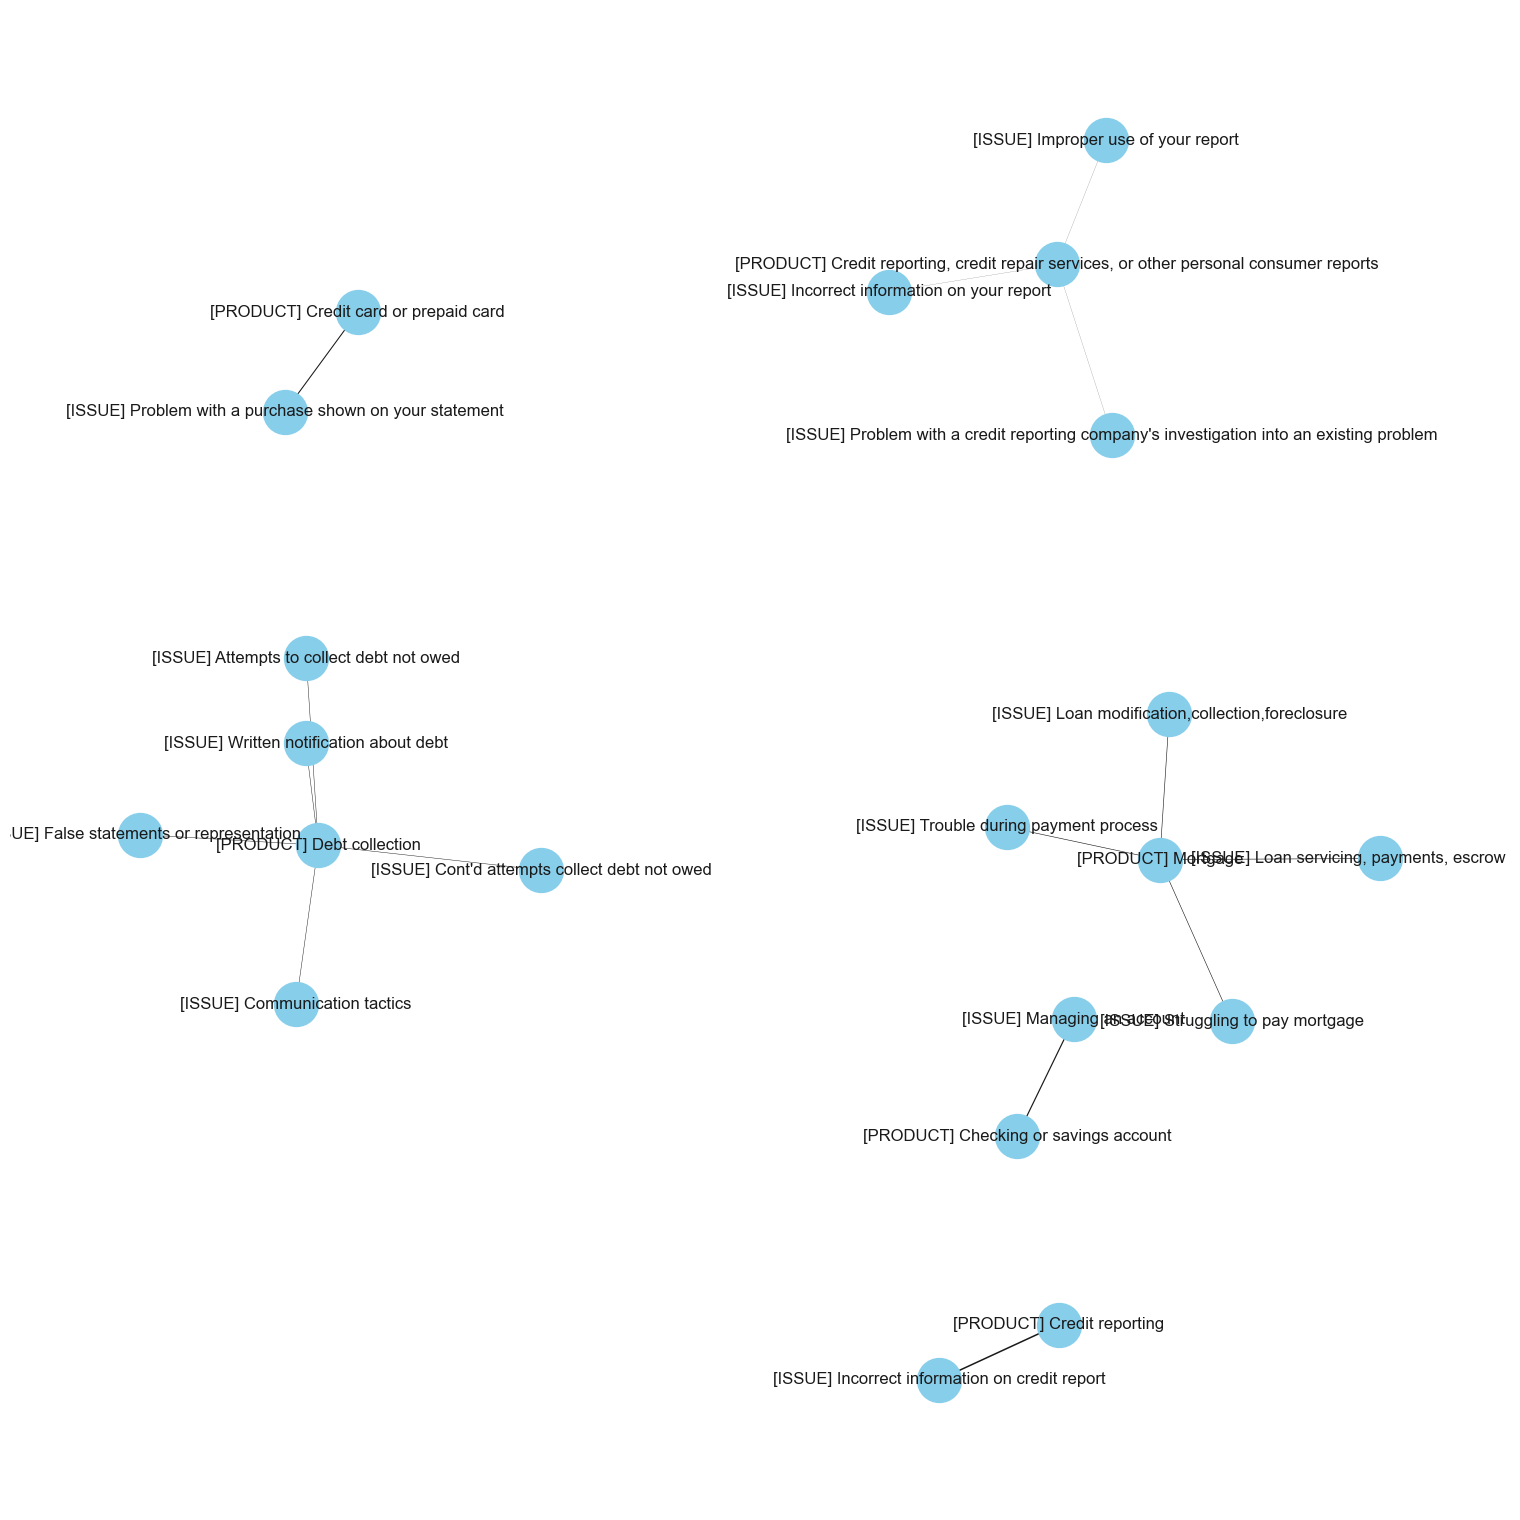

In [504]:
# plot the top 10 rules
plot_association_rules(top_10_rules)


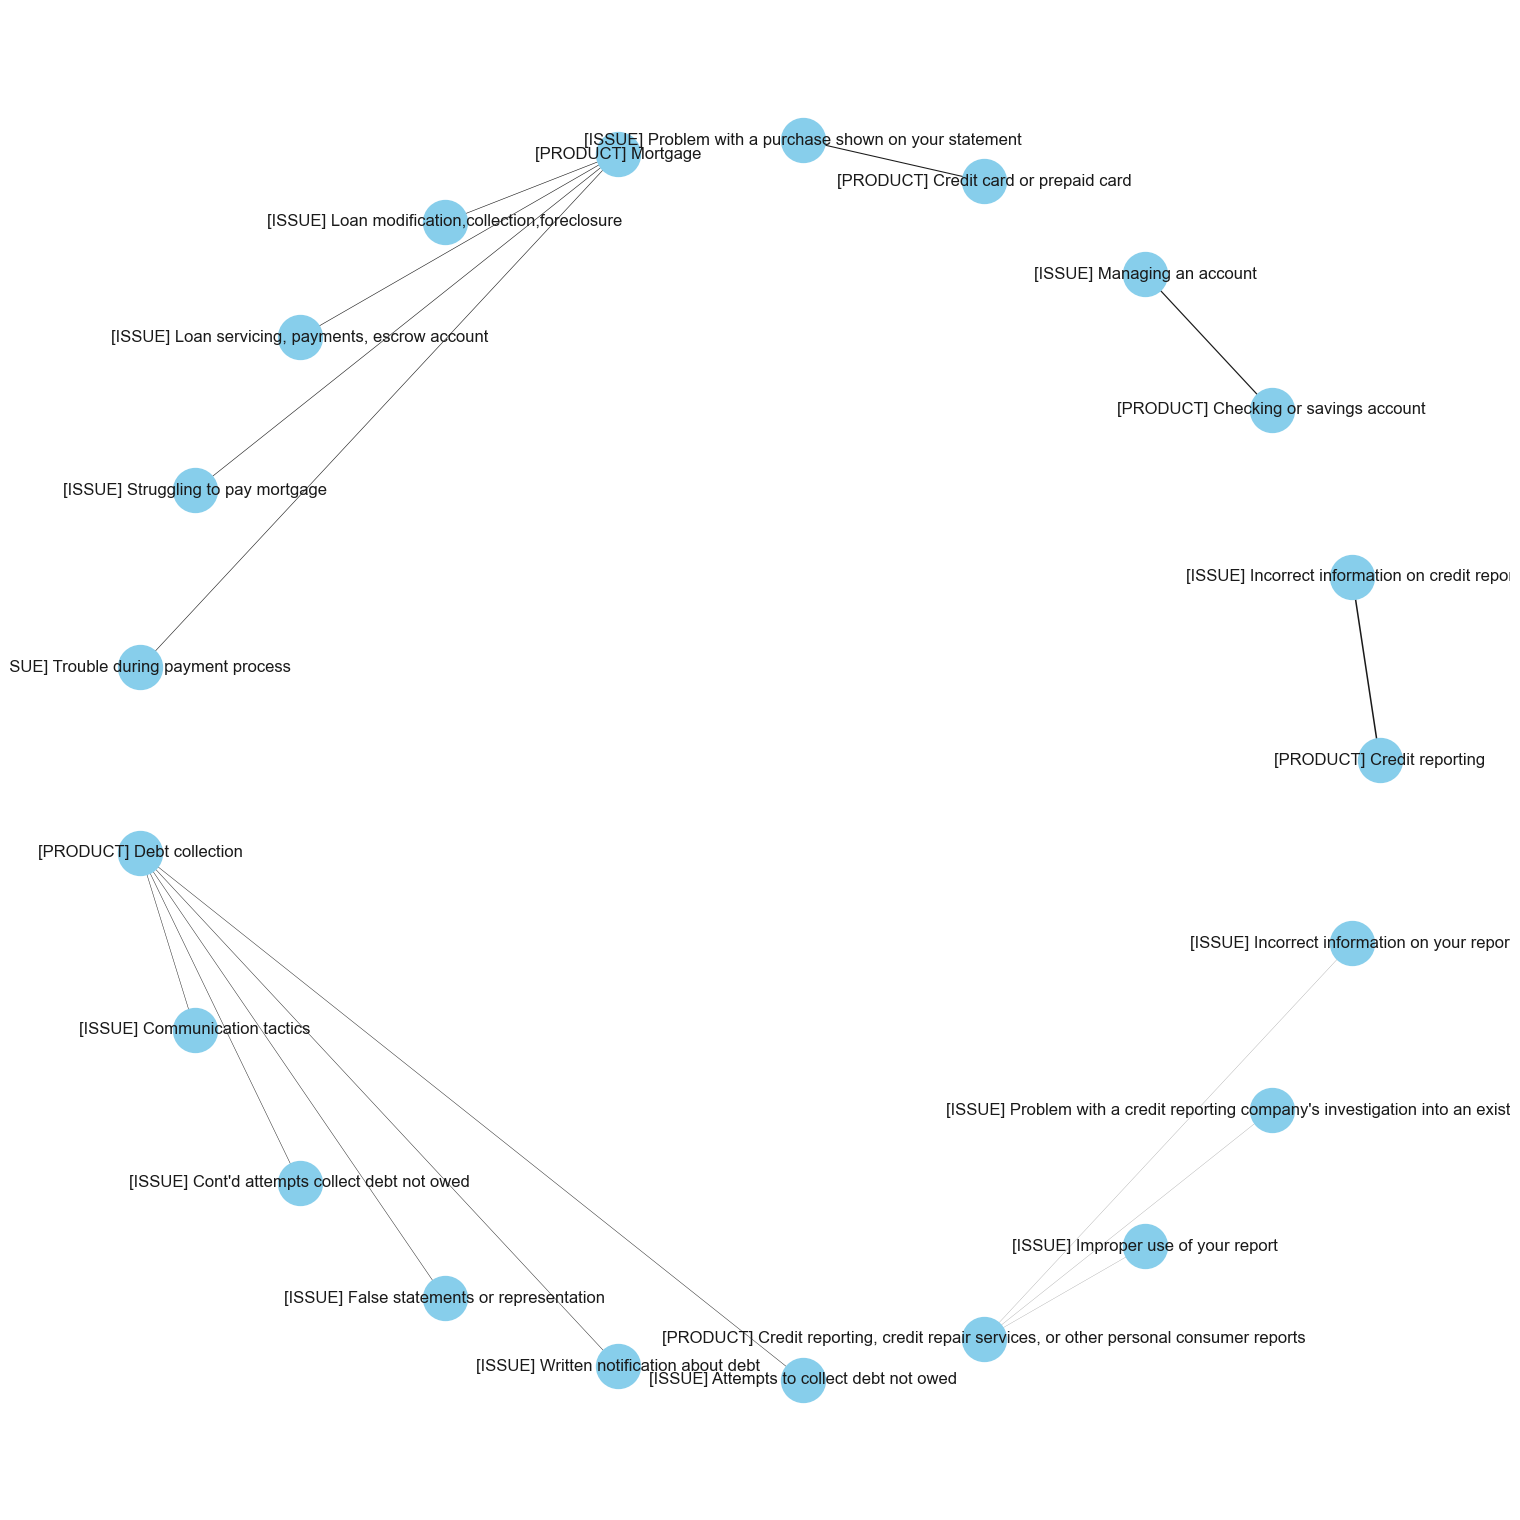

In [505]:
# use circular layout
plot_association_rules(top_10_rules, layout=1)

#### Vis: Heatmap. metrics for the identified rules

In [516]:

def plot_rules_vs_metrics_heatmap(rules_df, metrics=['support', 'confidence', 'lift'], figsize=(15, 10)):
    """
    Plot a heatmap of association rules vs. their metrics.

    Parameters:
    - rules_df: DataFrame containing columns 'antecedents', 'consequents', and the desired metrics.
    - metrics: List of metrics to be plotted. Default is ['support', 'confidence', 'lift'].
    - figsize: Tuple specifying the size of the resulting plot.
    """

    # Create a new column in the dataframe for the rule (antecedent -> consequent)
    rules_df['rule'] = rules_df['antecedents'].astype(str) + ' -> ' + rules_df['consequents'].astype(str)

    # Create a new dataframe with rules as rows and metrics as columns
    heatmap_df = rules_df.set_index('rule')[metrics]

    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap_df, cmap='YlGnBu', annot=True)
    plt.title('Heatmap of Association Rules vs. Metrics')
    plt.show()


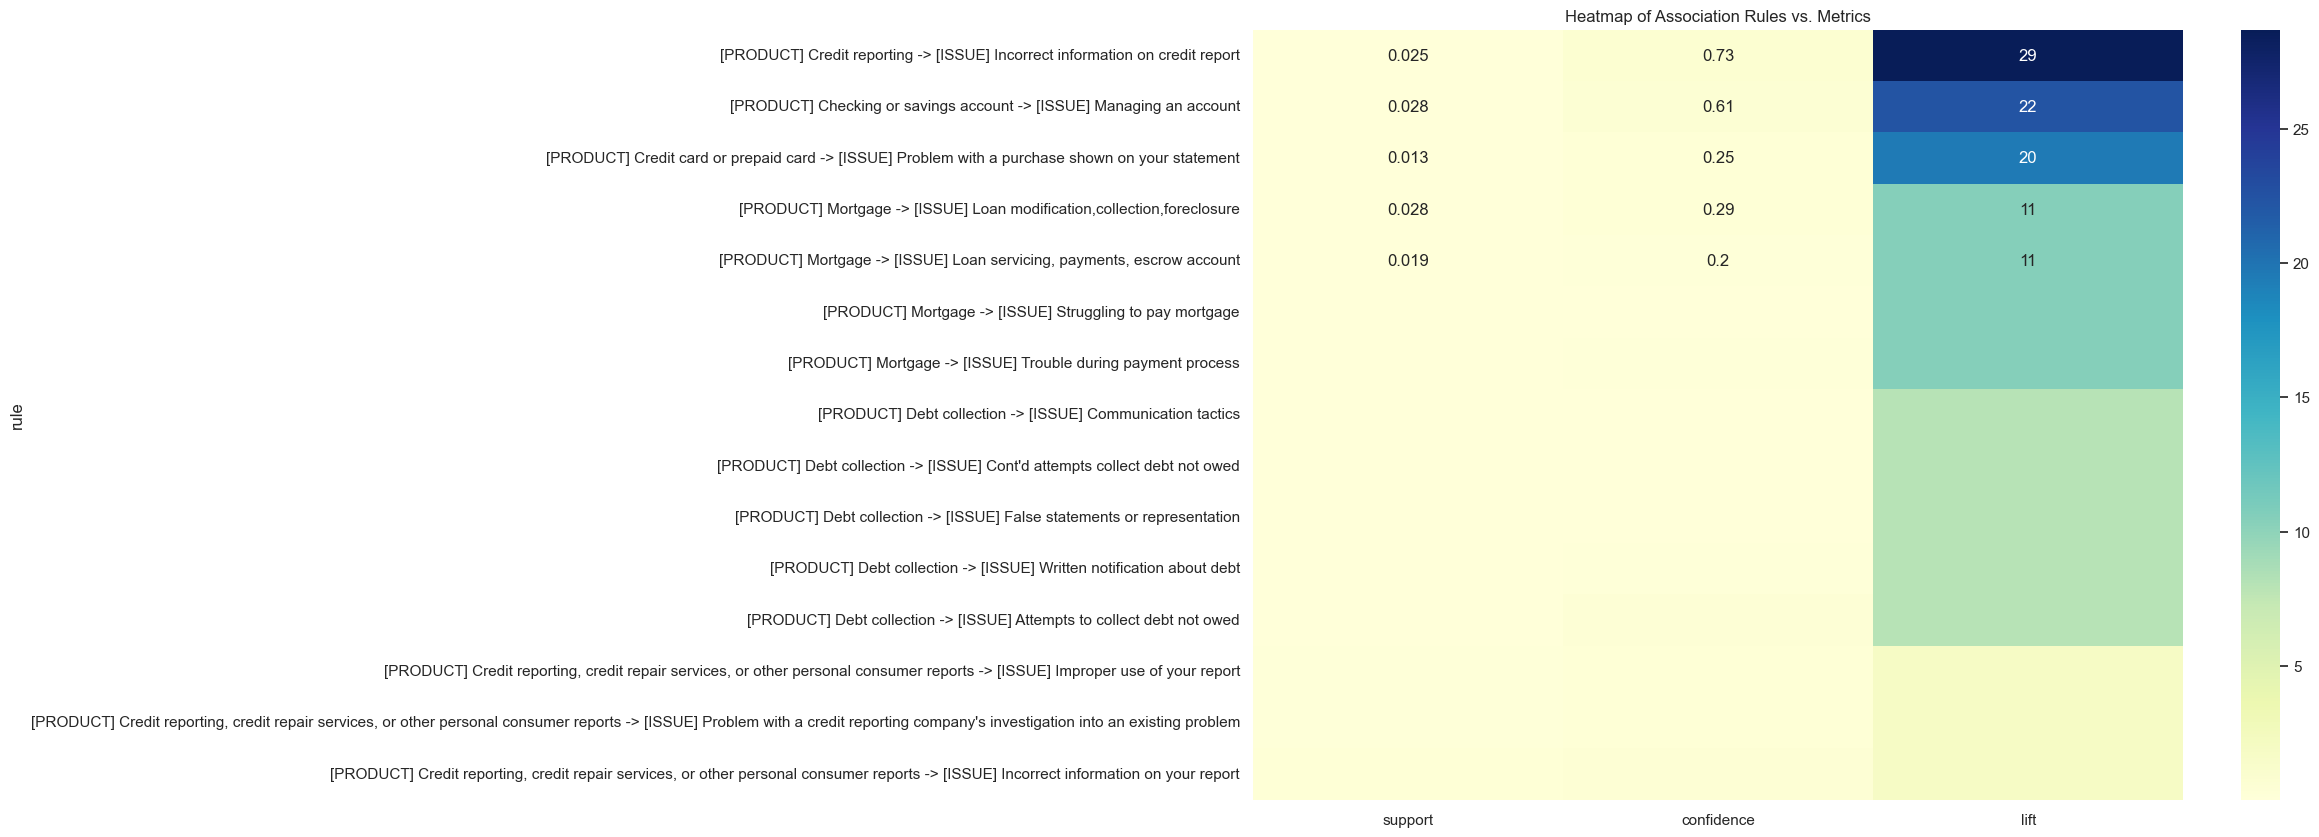

In [517]:
# plot heatmap
plot_rules_vs_metrics_heatmap(top_10_rules)

## 3. Finding Similar Complaints with Word2Vec and Cosine Similarity


In [518]:
# load pretrain word2vec model
model = KeyedVectors.load_word2vec_format(filepath02, binary=True)

In [519]:
# create a copy of the data
df3 = DATA.copy()

# print shape
print(df3.shape)

# drop null narratives
df3 = df3.dropna(subset=['Consumer complaint narrative'])

# print shape
print(df3.shape)

# drop duplicates in narratives
df3 = df3.drop_duplicates(subset=['Consumer complaint narrative'])

# print shape
print(df3.shape)

(4028530, 18)
(1460126, 18)
(1239244, 18)


In [520]:
# sample 1/100 of the data for faster processing and demonstration purposes
df3 = df3.sample(frac=0.01, random_state=42)

# print shape
print(df3.shape)

(12392, 18)


In [521]:
# preprocess the narrative column
df3['narrative_clean'] = df3['Consumer complaint narrative'].progress_apply(preprocess_narrative)

# drop duplicates in narrative_clean
df3 = df3.drop_duplicates(subset=['narrative_clean'])

# print shape
print(df3.shape)


  0%|          | 0/12392 [00:00<?, ?it/s]

100%|██████████| 12392/12392 [00:01<00:00, 10557.09it/s]

(12206, 19)


In [522]:
# func: compute the average word2vec vector for each complaint narrative, get_mean_vector

def get_mean_word2vec(narrative, model=model):

    # initialize vector
    vector = np.zeros(300)

    # get all words in narrative
    words = narrative.split()
    num_words = len(words)

    if num_words == 0:  # edge case: empty narrative
        return vector

    # calculate word vectors using list comprehension
    word_vectors = [model[word] for word in words if word in model]

    if word_vectors:
        vector = np.mean(word_vectors, axis=0)

    return vector

In [523]:
# compute the average word2vec vector for each complaint narrative
df3['narrative_vector'] = df3['narrative_clean'].progress_apply(lambda x: get_mean_word2vec(x))

100%|██████████| 12206/12206 [00:03<00:00, 4039.71it/s]


In [524]:
df3.narrative_vector.sample(5)

1482028    [-0.04194663, -0.011130513, 0.047042184, 0.033...
1887985    [-0.048648834, 0.049970355, 0.02065386, -0.022...
1037136    [-0.026330087, -0.0068251668, 0.026103599, -0....
3258797    [-0.0191585, 0.02465492, 0.006507601, -0.01208...
1004083    [-0.011526932, -0.018300185, 0.0061321342, 0.0...
Name: narrative_vector, dtype: object

In [525]:
# compute the cosine similarity between the average word2vec vectors of each complaint narrative

# convert the narrative vectors to numpy arrays
narrative_vectors = np.array(df3['narrative_vector'].tolist())

# print shape
print(narrative_vectors.shape)

# compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(narrative_vectors, narrative_vectors)

# print shape
print(cosine_sim_matrix.shape)


(12206, 300)
(12206, 12206)


In [526]:
# Show most 10 similar complaints for any randomly selected complaint

# randomly select 5 complaints
random.seed(42)
random_indices = random.sample(range(0, len(df3)), 5)

# print the top 10 most similar complaints for each randomly selected complaint
for index in random_indices:
    print(f"Complaint: \n'{df3['Consumer complaint narrative'].iloc[index]}'")
    print('')
    print('Top 10 most similar complaints:')
    sorted_indices = cosine_sim_matrix[index].argsort()[-2:-12:-1]  # We start at -2 because the most similar item is itself
    print(df3['Consumer complaint narrative'].iloc[sorted_indices].values)
    print('')
    print('Cosine similarity scores: ')
    print(cosine_sim_matrix[index][sorted_indices])
    print('')
    print('------------------------------------------------------------------------------------------------------------------')


Complaint: 
'I am requesting my mortgage services to report my payments to the credit bureau. My servicer is Specialize Loan Servicing. I contacted them last month requesting my payments to be reported to the bureaus. I was told that on record it shows that I filed a chapter XXXX bankruptcy. I did file a chapter XXXX in XXXX which was discharged in XXXX. Also. I know by law that cant report but in XXXX my husband and I filed a chapter XXXX repayment plan. We paid our mortgage through the plan and received a discharge in XXXX. I spoke with my attorney about why the mortgage company wasnt reporting my payments. My attorney office states once we received our discharge the mortgage company should be reporting my payments to the bureau. Im trying to get some much needed repairs do e on my home and each time I try to get a loan Im told I dont have a long history of payments. That is ridiculous because Ive been paying a mortgage since XXXX! The problem is theres no record on my credit report.

#### Vis: T-SNE of the word embeddings. reduced vectors as a scatter plot, colored by product category.

In [527]:
# viz: plot the t-SNE reduced vectors as a scatter plot, colored by product|
# plot the t-SNE reduced vectors as a scatter plot, colored by product (top 5 products)

# convert the narrative vectors to numpy arrays
narrative_vectors = np.array(df3['narrative_vector'].tolist())

# print shape
print(narrative_vectors.shape)

# reduce the dimensionality of the narrative vectors to 2 dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
narrative_vectors_2d = tsne.fit_transform(narrative_vectors)

# print shape
print(narrative_vectors_2d.shape)


(12206, 300)
(12206, 2)


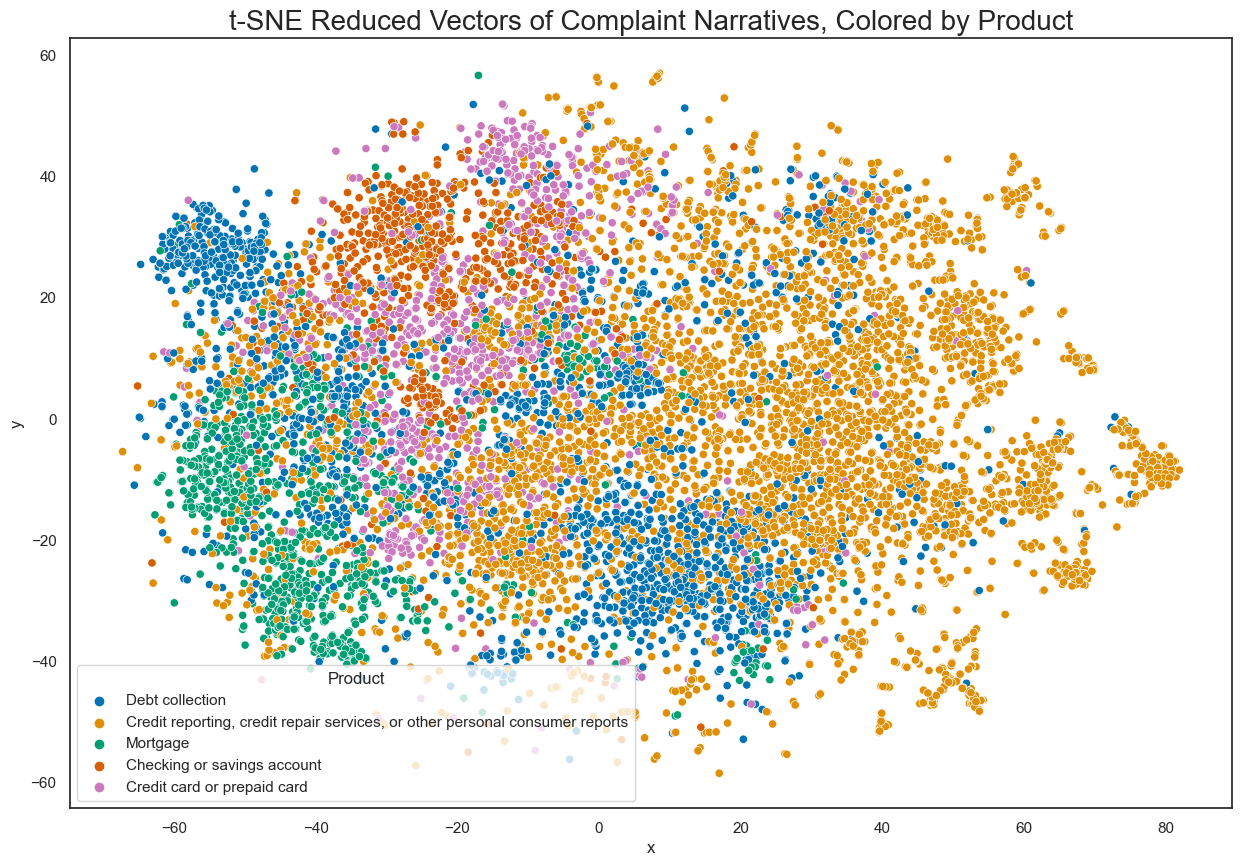

In [528]:
# create a dataframe with the 2d vectors and the product
df_tsne = pd.DataFrame(narrative_vectors_2d, columns=['x', 'y'])
df_tsne['Product'] = df3['Product'].values

 
# select top n products
n = 5
top_n_products = df_tsne['Product'].value_counts().head(n).index.tolist()

# filter the dataframe to only include the top n products
df_tsne_top_n = df_tsne[df_tsne['Product'].isin(top_n_products)]


# plot the t-SNE reduced vectors as a scatter plot, colored by product

plt.figure(figsize=(15, 10))
sns.set_style('white')
sns.scatterplot(x='x', y='y', hue='Product', data=df_tsne_top_n, palette='colorblind')
plt.title('t-SNE Reduced Vectors of Complaint Narratives, Colored by Product', fontsize=20)
plt.show()


#### Vis: t-SNE reduced vectors as a scatter plot, colored by issue

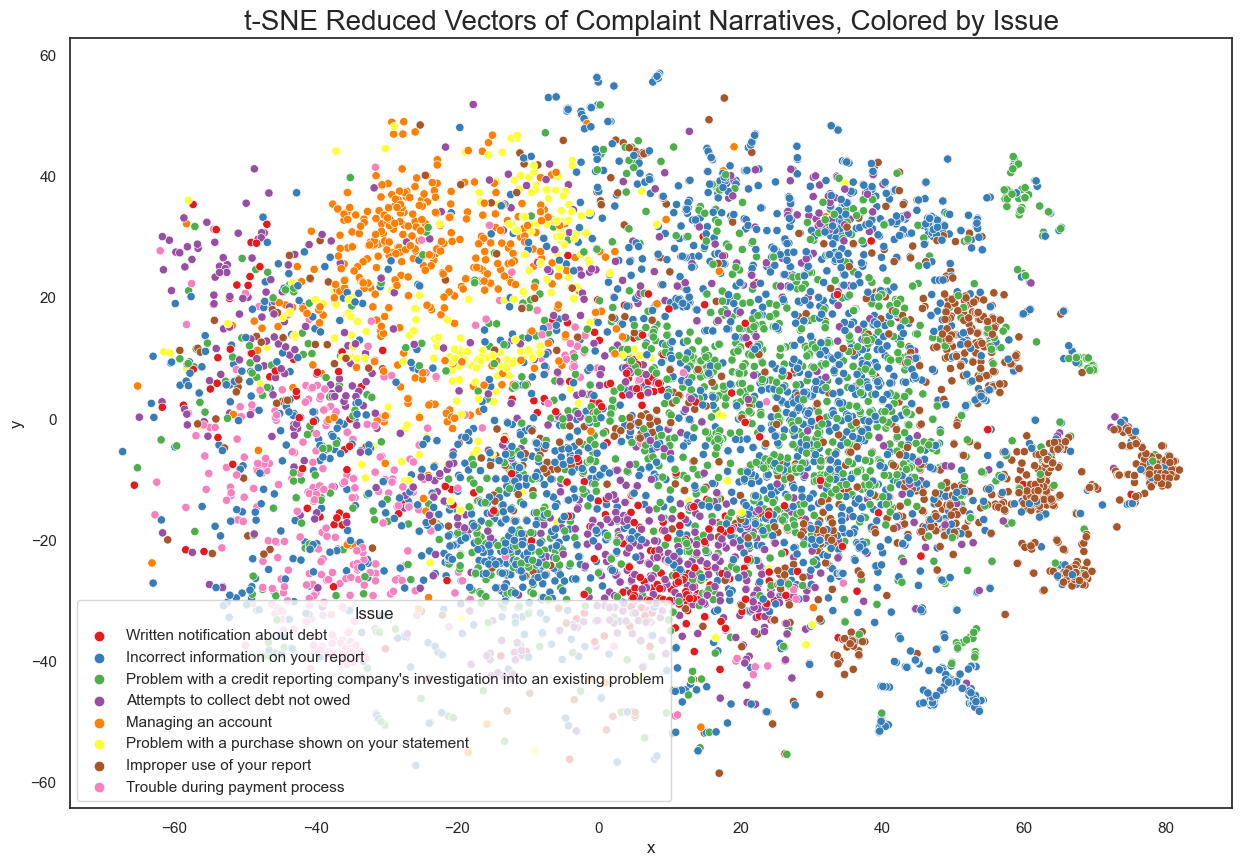

In [536]:
# vis t-SNE reduced vectors as a scatter plot, colored by issue

# select top n issues
n = 8
top_n_issues = df3['Issue'].value_counts().head(n).index.tolist()

# create a dataframe with the 2d vectors and the issue
df_tsne = pd.DataFrame(narrative_vectors_2d, columns=['x', 'y'])
df_tsne['Issue'] = df3['Issue'].values

# filter the dataframe to only include the top n issues
df_tsne_top_n = df_tsne[df_tsne['Issue'].isin(top_n_issues)]

# plot the t-SNE reduced vectors as a scatter plot, colored by issue

plt.figure(figsize=(15, 10))
sns.set_style('white')
sns.scatterplot(x='x', y='y', hue='Issue', data=df_tsne_top_n, palette='Set1')
plt.title('t-SNE Reduced Vectors of Complaint Narratives, Colored by Issue', fontsize=20)
plt.show()


#### Vis: Histogram of Cosine Similarity Scores:

To visualize the distribution of similarity scores among complaints

It will help understand if most complaints are unique or if there are many that are very similar.

(148986436,)


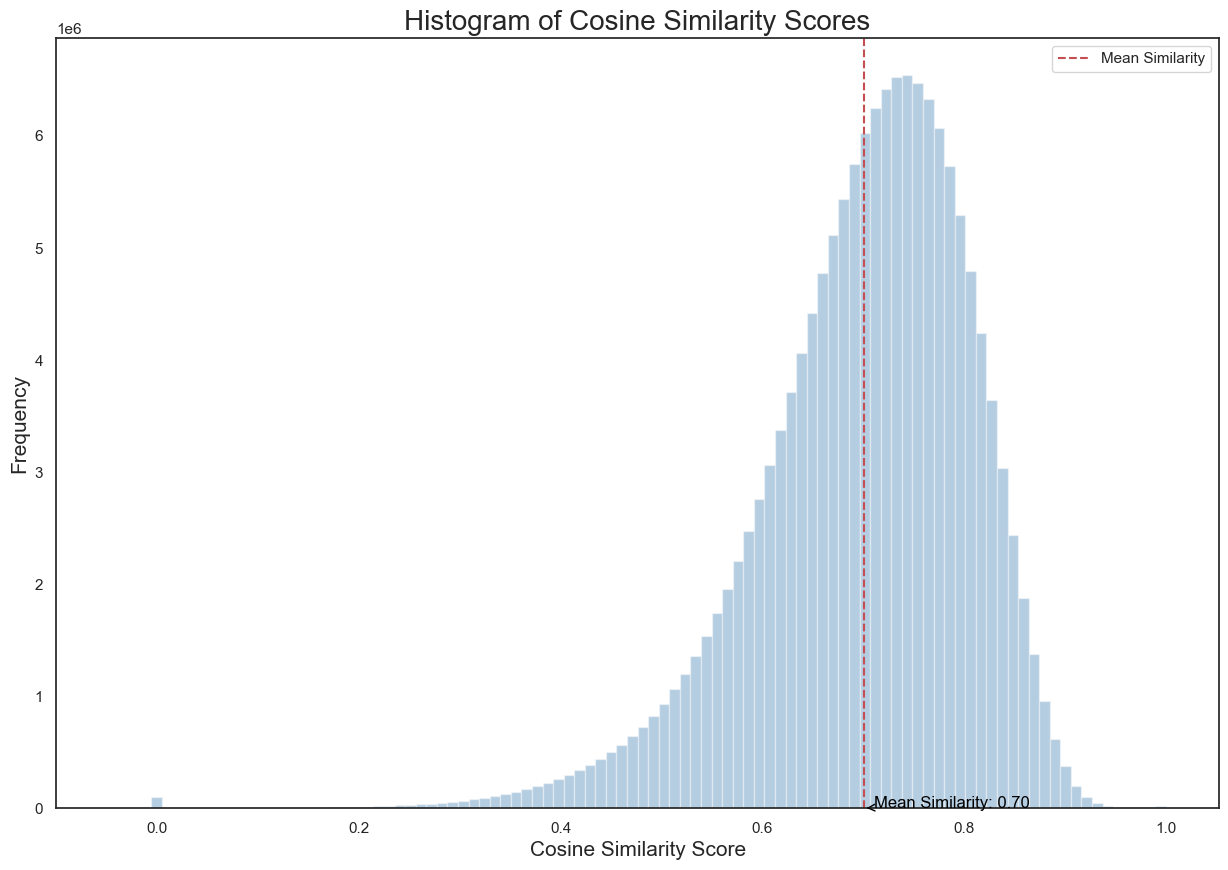

In [543]:
# Histogram of Cosine Similarity Scores

# convert the cosine similarity matrix to a 1d array
cosine_sim_scores = cosine_sim_matrix.flatten()

# print shape
print(cosine_sim_scores.shape)

# Calculate mean of cosine similarities 
mean_similarity = np.mean(cosine_sim_scores)

# Original histogram plot
plt.figure(figsize=(15, 10))
sns.distplot(cosine_sim_scores, bins=100, kde=False, color='steelblue') 

# Add vertical line for mean 
plt.axvline(mean_similarity, color='r', linestyle='--')

plt.annotate(
    f'Mean Similarity: {mean_similarity:.2f}',  # Text to display
    xy=(mean_similarity, 0),  # Position of the text (x, y)
    xytext=(mean_similarity + 0.01, 200),  # Text position (x, y)
    textcoords='data',  # Coordinate system for xytext
    arrowprops=dict(arrowstyle='->', color='black'),  # Arrow style
    fontsize=12,  # Font size
    color='black',  # Text color
)


plt.title('Histogram of Cosine Similarity Scores', fontsize=20)
plt.xlabel('Cosine Similarity Score', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

# Add legend
plt.legend(['Mean Similarity'], loc='upper right')

plt.show()

## 4. Clustering Companies based on Complaints: 

Apply clustering algorithms (e.g., K-means) to group companies that receive similar types of complaints. 

This can help in identifying companies that might have similar operational issues.

In [359]:
data = DATA.copy()

# drop null narratives
data = data.dropna(subset=['Consumer complaint narrative'])

# print shape
print(data.shape)

(1460126, 18)


In [360]:
# sample 1/10 of the data for faster processing and demonstration purposes
data = data.sample(frac=0.1, random_state=42)

# print shape
print(data.shape)


(146013, 18)


In [361]:
# preprocess the narrative column
data['narrative_clean'] = data['Consumer complaint narrative'].progress_apply(preprocess_narrative)

  0%|          | 0/146013 [00:00<?, ?it/s]

100%|██████████| 146013/146013 [00:15<00:00, 9659.44it/s] 


In [402]:
# Combine all narratives for each company into a single text
company_combined_narratives = data.groupby('Company')['narrative_clean'].apply(' '.join)


# Display the first few combined narratives
# print(company_combined_narratives.head(3))

# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, max_features=1000, stop_words='english')

# convert the combined narratives for each company into a TF-IDF matrix
company_tfidf_matrix = tfidf_vectorizer.fit_transform(company_combined_narratives)
print(company_tfidf_matrix.shape)


(2937,)
(2937, 1000)


#### Vis: elbow method optimal k value for k-means clustering

Processing k-means: 100%|██████████| 50/50 [02:07<00:00,  2.56s/k]


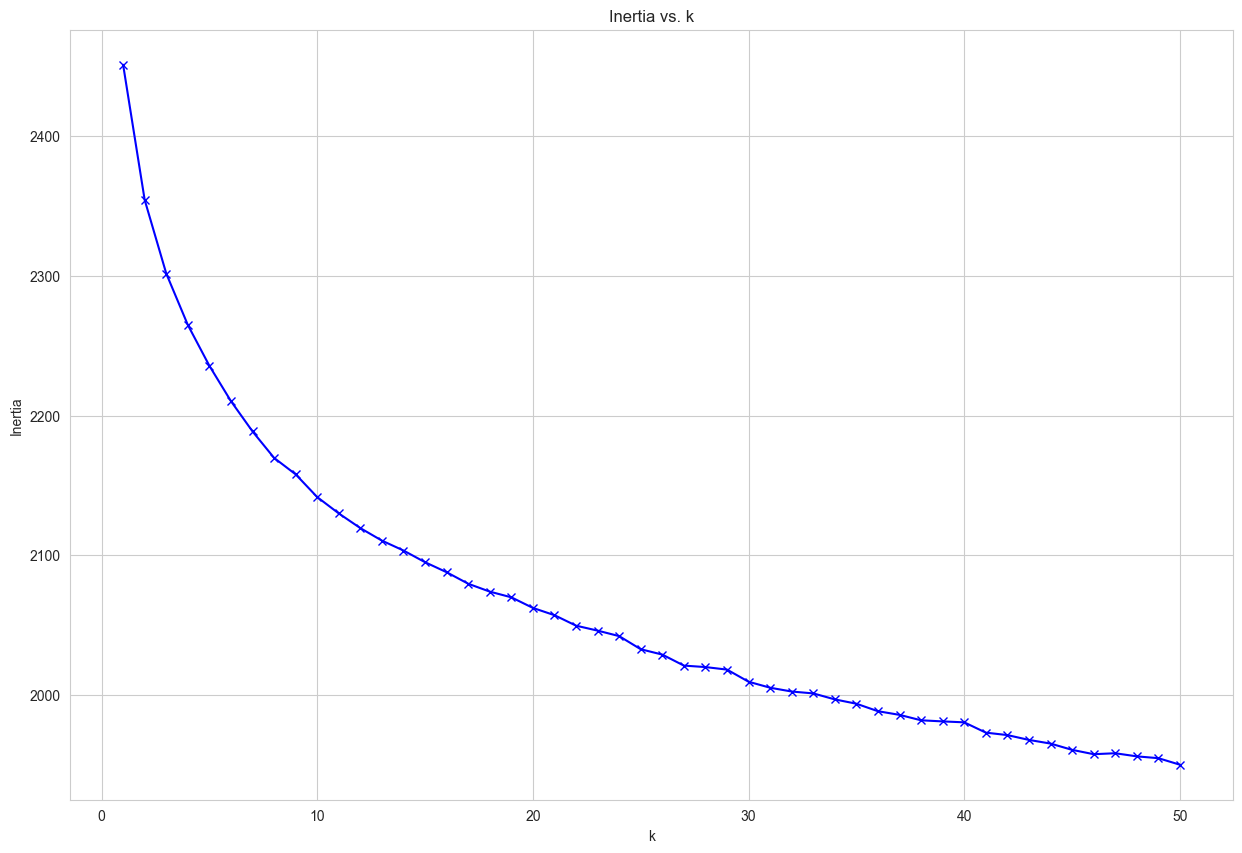

In [328]:
# k-means clustering, determine the optimal number of clusters using the elbow method

# Initialize a list to store the inertia values

inertia_values = []

# Initialize a range of k values to test

k_values = range(1, 51)

# Loop through each k value and calculate the inertia
for k in tqdm(k_values, desc='Processing k-means', unit='k'):

    # Initialize k-means with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Fit k-means to the TF-IDF matrix
    kmeans.fit(company_tfidf_matrix)

    # Append the inertia to the list of inertia values
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values against k values

plt.figure(figsize=(15, 10))
plt.plot(k_values, inertia_values, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Inertia vs. k')
plt.show()



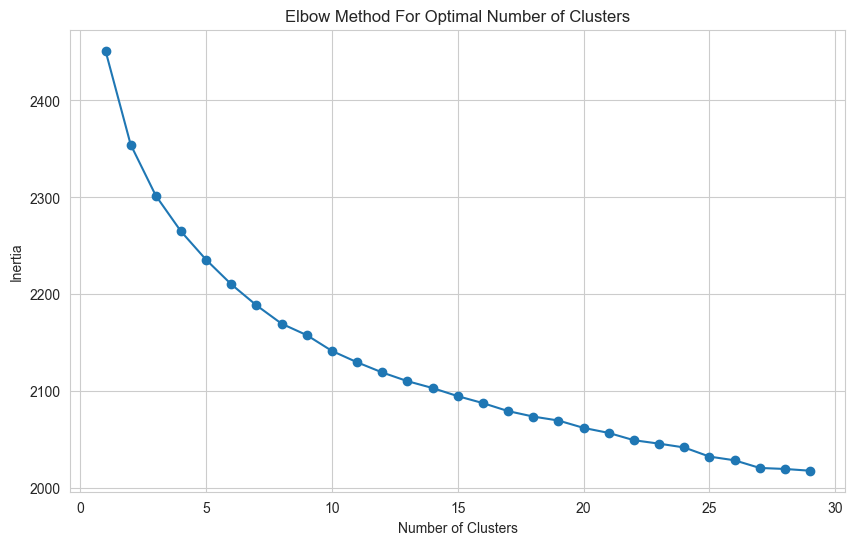

In [308]:
# re-run the elbow, zoom in to 1, 30

inertias = []
num_clusters = range(1, 30)

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(company_tfidf_matrix)
    inertias.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.grid(True)
plt.show()


Inertia measures compactness of clustering. Lower is better.
The Elbow Method finds the "sweet spot" where adding more clusters does not significantly improve inertia.
It balances between too few and too many clusters.

In [405]:
# Clustering using K-means (eyeballing optimal number of clusters)
N = 10

# Apply K-means clustering with N clusters
kmeans = KMeans(n_clusters=N, random_state=42)
company_clusters = kmeans.fit_predict(company_tfidf_matrix)

# Add the cluster labels to our company_combined_narratives Series
company_combined_narratives = company_combined_narratives.reset_index()
company_combined_narratives['Cluster'] = company_clusters

# Display the number of companies in each cluster
cluster_counts = company_combined_narratives['Cluster'].value_counts()
# cluster_counts

# display companies in each cluster

# for cluster in range(0, N):
#     print('Cluster {}:'.format(cluster))
#     print(company_combined_narratives[company_combined_narratives['Cluster'] == cluster]['Company'].values)
#     print('\n')


In [407]:
# spot check: print cluster 1's companies

companies_in_cluster_1 = company_combined_narratives[company_combined_narratives['Cluster'] == 1]['Company'].values

print(companies_in_cluster_1)

# eyeball cluster 1: almost all companies are banks

['ADP Inc.' 'ALASKA USA FEDERAL CREDIT UNION' 'ALLIANT CREDIT UNION'
 'AMALGAMATED TOKEN SERVICES, INC.' 'AMERICAN EXPRESS COMPANY'
 'APPLE FINANCIAL HOLDINGS, INC.' 'ASSOCIATED BANC-CORP'
 'AXOS FINANCIAL, INC.' 'Activehours' 'Albert Corporation'
 'Allied Credit Consultants' 'Argon Credit' 'Athena Bitcoin Inc'
 'Atlantic Union Bankshares, Inc.' 'Atlanticus Services Corporation'
 'BAM Management US Holdings Inc.' 'BANCO POPULAR DE PUERTO RICO'
 'BANCORPSOUTH BANK' 'BANK OF AMERICA, NATIONAL ASSOCIATION'
 'BANK OF HAWAII CORPORATION' 'BANK OF NEW YORK MELLON CORPORATION, THE'
 'BANK OF THE WEST' 'BANK OZK' 'BANKUNITED, NATIONAL ASSOCIATION'
 'BARCLAYS BANK DELAWARE' 'BB&T CORPORATION' 'BBVA FINANCIAL CORPORATION'
 'BERKSHIRE HILLS BANCORP, INC' 'BETHPAGE FEDERAL CREDIT UNION'
 'BILL.COM, LLC' 'BM Technologies, Inc.'
 'BMO HARRIS BANK NATIONAL ASSOCIATION' 'BOEING EMPLOYEES CREDIT UNION'
 'BOK FINANCIAL CORP' 'BUSEY BANK' 'Bastion Consumer Funding I, LLC'
 'Blackhawk Network Holdings Inc

In [417]:
# spot check: print cluster 5's companies

companies_in_cluster_5 = company_combined_narratives[company_combined_narratives['Cluster'] == 5]['Company'].values

print(companies_in_cluster_5)

['AC AutoPay LLC, Denver, CO Branch' 'AMERICA FIRST FEDERAL CREDIT UNION'
 'AMERICAN HONDA FINANCE CORP' 'AUTOMOBILE ACCEPTANCE CORPORATION'
 'AUTOMOTIVE CREDIT CORPORATION' 'Ace Motor Acceptance Corporation'
 'Advantage Auto Sales, Inc.' 'American Acceptance Co., LLC'
 'American Credit Acceptance, LLC' 'American Finance LLC'
 'Americas Car-Mart, Inc.' 'Arivo Acceptance, LLC'
 'Auto Credit of Southern Ilinois'
 'Auto Now Financial Services, Inc., Phoenix, AZ Branch' 'Auto Trakk, LLC'
 'Avantus, LLC' 'Avid Acceptance, LLC' 'BAY COUNTRYCONSUMER FINANCE,INC.'
 'BAYSIDE CREDIT' 'BMW Financial Services NA, LLC' 'BTS Motors, LLC'
 'BUCKEYE FINANCIAL SERVICES OF ALLIANCE INC.'
 'Bridgecrest Acceptance Corporation' 'Byrider Franchising, LLC'
 'CARS Acquisition, LLC' 'CCM Finance LLC' 'CFS of Aurora IL LLC'
 'CHALLENGE FINANCIAL SERVICES' 'CJA Auto Sales, Inc.' 'CMM Finance, Inc.'
 'COMPUTER SCIENCES CORPORATION' 'CONDOR CAPITAL CORP'
 'CREDIT ACCEPTANCE CORPORATION' 'CREDIT CONCEPTS, INC.'
 'C

#### Vis: number of companies in each cluster

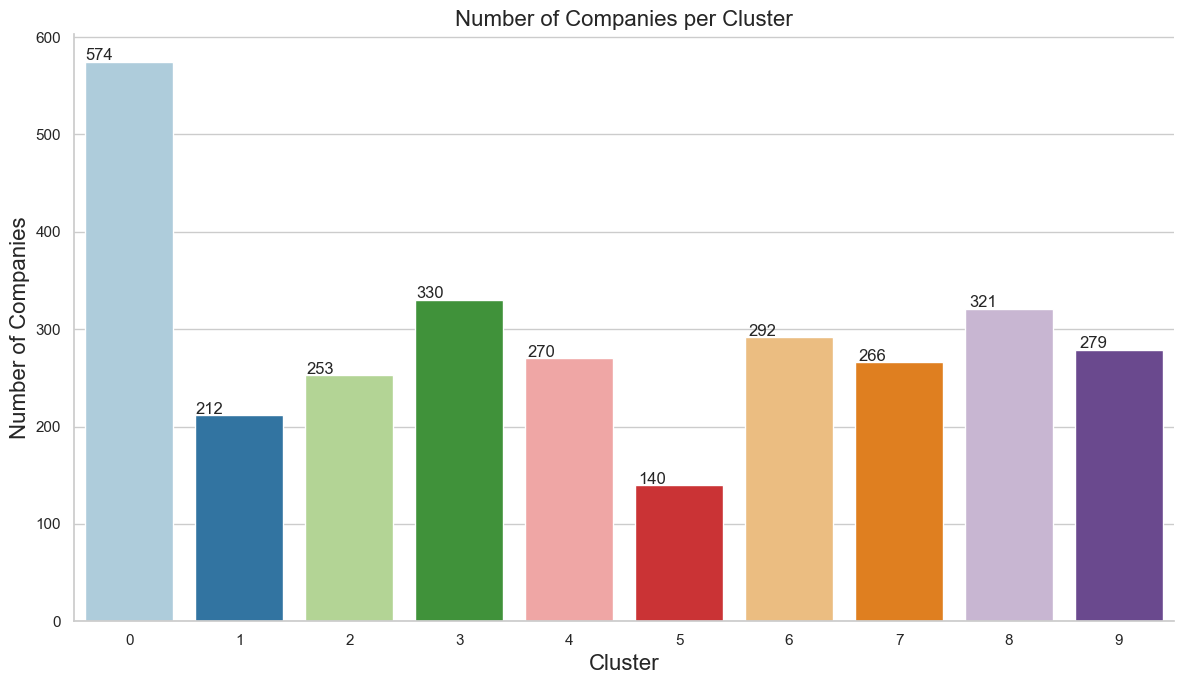

In [446]:
# Use seaborn theme for white grid
sns.set_theme(style="whitegrid") 

font_size = 16

colors = sns.color_palette('Paired', 10)

# Plot bar chart
plt.figure(figsize=(12,7))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, 
                 palette=colors)

# Add value labels on bars
for p in ax.patches:

    val = '{:.0f}'.format(p.get_height())

    ax.annotate(val, (p.get_x() * 1.005, p.get_height() * 1.005))
    
# Set titles and labels    
plt.title('Number of Companies per Cluster', fontsize=font_size)  
plt.xlabel('Cluster', fontsize=font_size)
plt.ylabel('Number of Companies', fontsize=font_size)

# Despine and tidy up    
sns.despine()
plt.tight_layout()
plt.show()

#### Vis: word cloud of the most frequent words in a cluster

In [544]:
# display the top 10 terms for given cluster

def display_wordcloud(cluster):
    # Get the top terms for the cluster
    terms = tfidf_vectorizer.get_feature_names_out()
    tfidf_array = company_tfidf_matrix.toarray()
    cluster_terms = tfidf_array[company_combined_narratives['Cluster'] == cluster].mean(axis=0)
    terms_dict = {terms[i]: cluster_terms[i] for i in range(len(terms))}
    
    # Create and display the word cloud
    wordcloud = WordCloud(background_color="white", width=800, height=400).generate_from_frequencies(terms_dict)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Cluster {}'.format(cluster))
    plt.show()


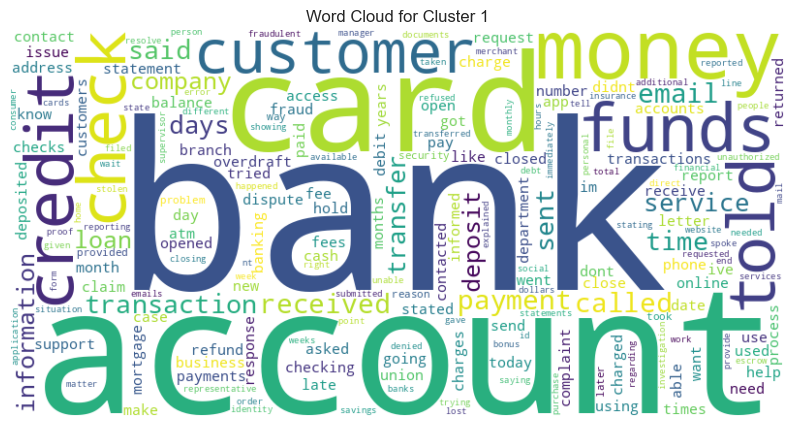

In [545]:
# Display word cloud for a chosen cluster 
display_wordcloud(1)

# eyeball cluster 1: bank related 

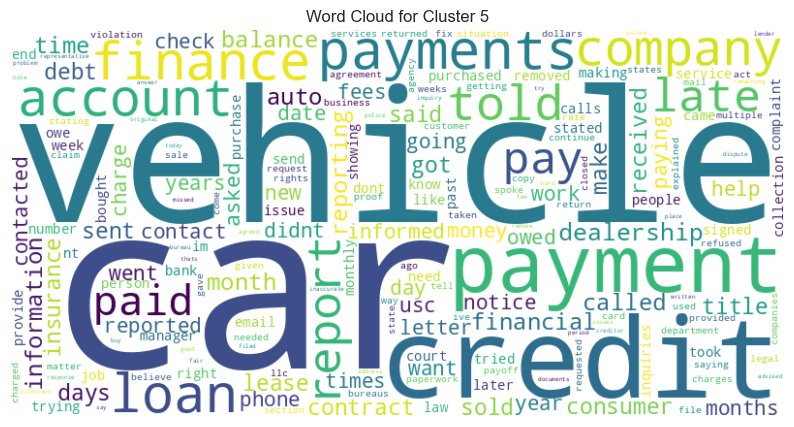

In [546]:
display_wordcloud(5)

# eyeballing cluster 5: car, vehicle related complaints